In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [2]:
from google.colab import files

uploaded = files.upload()

Saving orders_and_shipments_final_cleaned.csv to orders_and_shipments_final_cleaned.csv


In [6]:
df = pd.read_csv("orders_and_shipments_final_cleaned.csv")
df.head(5)

,Order Time,Order Quantity,Product Department,Product Category,Product Name,Customer Market,Customer Region,Customer Country,Warehouse Country,Shipment Mode,Shipment Days - Scheduled,Order Date,Shipment Date,Region
0,14:07,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,LATAM,Central America,Mexico,Puerto Rico,Standard Class,4,2/21/2015,2/27/2015,Latin America
1,7:37,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,LATAM,South America,Brazil,Puerto Rico,Standard Class,4,3/2/2015,3/6/2015,Latin America
2,22:47,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,LATAM,Central America,Mexico,Puerto Rico,Standard Class,4,4/18/2015,4/20/2015,Latin America
3,22:32,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,Europe,Northern Europe,Denmark,Puerto Rico,Standard Class,4,6/10/2015,6/12/2015,Europe
4,22:32,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,Europe,Northern Europe,Denmark,Puerto Rico,Standard Class,4,6/10/2015,6/12/2015,Europe


***Initial Business and Supply Chain Metrics Calculation***

***Subtask:***

Calculate fundamental business metrics such as total sales, average order value, profit margins, and key supply chain metrics like inventory turnover, lead times, and on-time delivery rates, based on the structure of the cleaned data.

In [9]:

total_order_quantity = df["Order Quantity"].sum()
average_order_quantity = df["Order Quantity"].mean()

df["Order Date"] = pd.to_datetime(df["Order Date"])
df["Shipment Date"] = pd.to_datetime(df["Shipment Date"])

df["Actual Shipment Days"] = (df["Shipment Date"] - df["Order Date"]).dt.days

average_lead_time = df["Actual Shipment Days"].mean()

df["On-Time Delivery"] = df["Actual Shipment Days"] <= df["Shipment Days - Scheduled"]
percentage_on_time_delivery = df["On-Time Delivery"].mean() * 100

print(f"Total Order Quantity: {total_order_quantity}")
print(f"Average Order Quantity: {average_order_quantity:.2f}")
print(f"Average Actual Shipment Duration (Lead Time): {average_lead_time:.2f} days")
print(f"Percentage of On-Time Deliveries: {percentage_on_time_delivery:.2f}%")

print(
    "\nNote: Total sales, average order value, profit margins, and inventory turnover\n"
    "cannot be accurately calculated without specific price and cost data,\n"
    "which is not available in the current DataFrame."
)



Total Order Quantity: 66367
Average Order Quantity: 2.15
Average Actual Shipment Duration (Lead Time): 3.56 days
Percentage of On-Time Deliveries: 56.46%

Note: Total sales, average order value, profit margins, and inventory turnover
cannot be accurately calculated without specific price and cost data,
which is not available in the current DataFrame.


Clean and standardize column names: lowercase, replace non-alphanumeric characters with '_',
collapse multiple underscores, and remove leading/trailing underscores

In [10]:
df.columns = (
    df.columns.str.lower()
    .str.replace(r"[^a-z0-9_]", "_", regex=True)
    .str.replace(r"__+", "_", regex=True)
    .str.strip("_")
)


In [26]:
# Find the scheduled shipment days column
scheduled_days_column_candidates = [
    col for col in df.columns if "shipment_days" in col and "scheduled" in col
]

if len(scheduled_days_column_candidates) == 1:
    scheduled_days_column = scheduled_days_column_candidates[0]
else:
    scheduled_days_column = None  # Column not found

# Calculate order quantities
total_order_quantity = df["order_quantity"].sum()
average_order_quantity = df["order_quantity"].mean()

# Convert dates
df["order_date"] = pd.to_datetime(df["order_date"])
df["shipment_date"] = pd.to_datetime(df["shipment_date"])

# Calculate actual shipment days and average lead time
df["actual_shipment_days"] = (df["shipment_date"] - df["order_date"]).dt.days
average_lead_time = df["actual_shipment_days"].mean()

# Only proceed if scheduled_days_column exists
if scheduled_days_column:
    df["scheduled_shipment_days_num"] = (
        df[scheduled_days_column]
        .astype(str)
        .str.split(r"\s+", n=1, expand=True)[0]
        .astype(int)
    )
    df["on_time_delivery"] = df["actual_shipment_days"] <= df["scheduled_shipment_days_num"]
    percentage_on_time_delivery = df["on_time_delivery"].mean() * 100
else:
    print("Scheduled shipment days column not found. Skipping related calculations.")
    percentage_on_time_delivery = None

# Print results
print(f"Total Order Quantity: {total_order_quantity}")
print(f"Average Order Quantity: {average_order_quantity:.2f}")
print(f"Average Actual Shipment Duration (Lead Time): {average_lead_time:.2f} days")
if percentage_on_time_delivery is not None:
    print(f"Percentage of On-Time Deliveries: {percentage_on_time_delivery:.2f}%")

print(
    "\nNote: Total sales, average order value, profit margins, and inventory turnover "
    "cannot be accurately calculated without specific price and cost data, which is not available in the current DataFrame."
)

print(df.columns.tolist())


Scheduled shipment days column not found. Skipping related calculations.
Total Order Quantity: 66367
Average Order Quantity: 2.15
Average Actual Shipment Duration (Lead Time): 3.56 days

Note: Total sales, average order value, profit margins, and inventory turnover cannot be accurately calculated without specific price and cost data, which is not available in the current DataFrame.
['order_time', 'order_quantity', 'product_department', 'product_category', 'product_name', 'customer_market', 'customer_region', 'customer_country', 'warehouse_country', 'shipment_mode', 'shipment_days_scheduled', 'order_date', 'shipment_date', 'region', 'actual_shipment_days', 'on_time_delivery', 'scheduled_shipment_days_num']


For advanced analysis, we will select the relevant features, apply one-hot encoding to categorical variables, and split the data into training and testing sets. Then, I will train a RandomForestRegressor model and evaluate its performance using MAE and R-squared, uncovering deeper insights and patterns in the data.

In [30]:
# 1. Select relevant numerical and categorical features
numerical_features = ["order_quantity"]
categorical_features = [
    "shipment_mode",
    "customer_market",
    "customer_region",
    "customer_country",
    "warehouse_country",
]
target = "actual_shipment_days"

X = df[numerical_features + categorical_features]
y = df[target]

# 2. Apply one-hot encoding to the selected categorical features
# Create a column transformer for one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ],
    remainder="passthrough",  # Keep numerical features as they are
)

# 3. Split the preprocessed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Train a RandomForestRegressor model
# Create a pipeline that first preprocesses the data and then trains the model
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", RandomForestRegressor(n_estimators=100, random_state=42)),
    ]
)

model.fit(X_train, y_train)

# 5. Evaluate the model's performance on the test set
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared: {r_squared:.2f}")


Mean Absolute Error (MAE): 57.55
R-squared: -0.07


Creating a series of advanced visualizations to clearly present insights from business, supply chain, and advanced analyses. These visualizations may include interactive plots, heatmaps, distribution charts, and time-series charts with forecasts, with all plots featuring clear legends to ensure easy interpretation

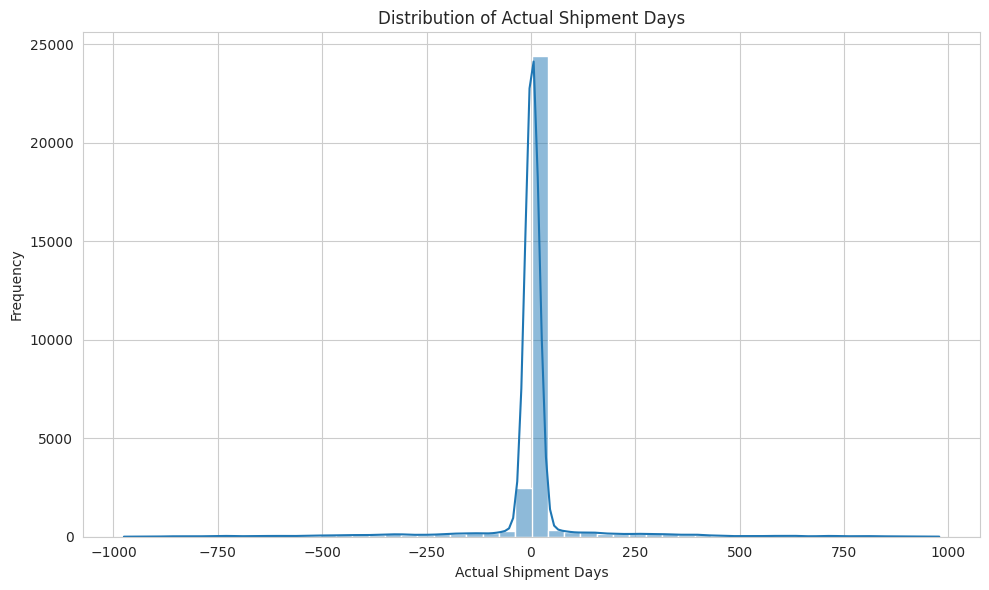

In [34]:
# Set a style for better aesthetics
sns.set_style("whitegrid")

# 1. Histogram for 'actual_shipment_days'
plt.figure(figsize=(10, 6))
sns.histplot(df["actual_shipment_days"], kde=True, bins=50)
plt.title("Distribution of Actual Shipment Days")
plt.xlabel("Actual Shipment Days")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


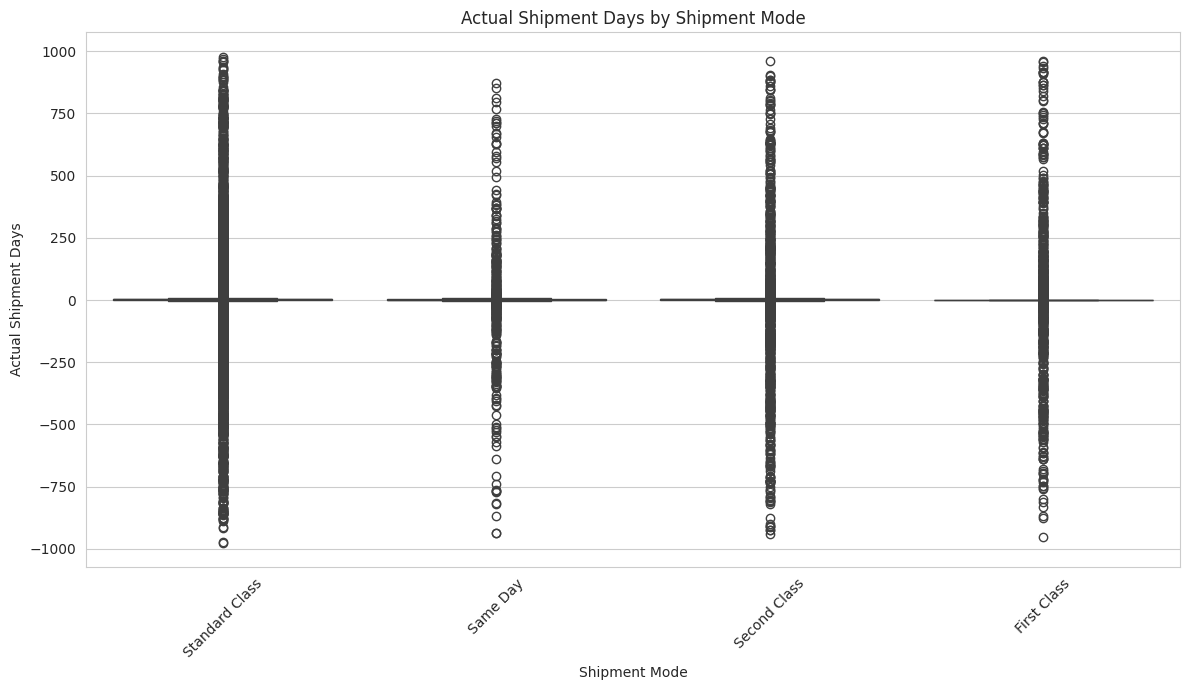

In [40]:
# 3. Box plot to show relationship between 'shipment_mode' and 'actual_shipment_days'
plt.figure(figsize=(12, 7))
sns.boxplot(x="shipment_mode", y="actual_shipment_days", data=df)
plt.title("Actual Shipment Days by Shipment Mode")
plt.xlabel("Shipment Mode")
plt.ylabel("Actual Shipment Days")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

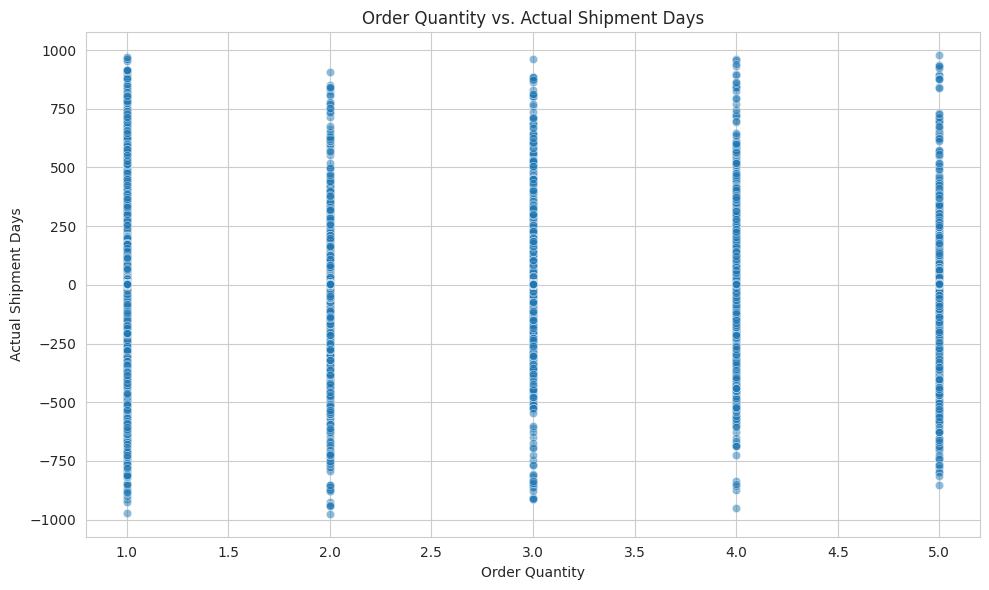

In [43]:
# 4. Scatter plot for 'order_quantity' and 'actual_shipment_days'
plt.figure(figsize=(10, 6))
sns.scatterplot(x="order_quantity", y="actual_shipment_days", data=df, alpha=0.5)
plt.title("Order Quantity vs. Actual Shipment Days")
plt.xlabel("Order Quantity")
plt.ylabel("Actual Shipment Days")
plt.tight_layout()
plt.show()



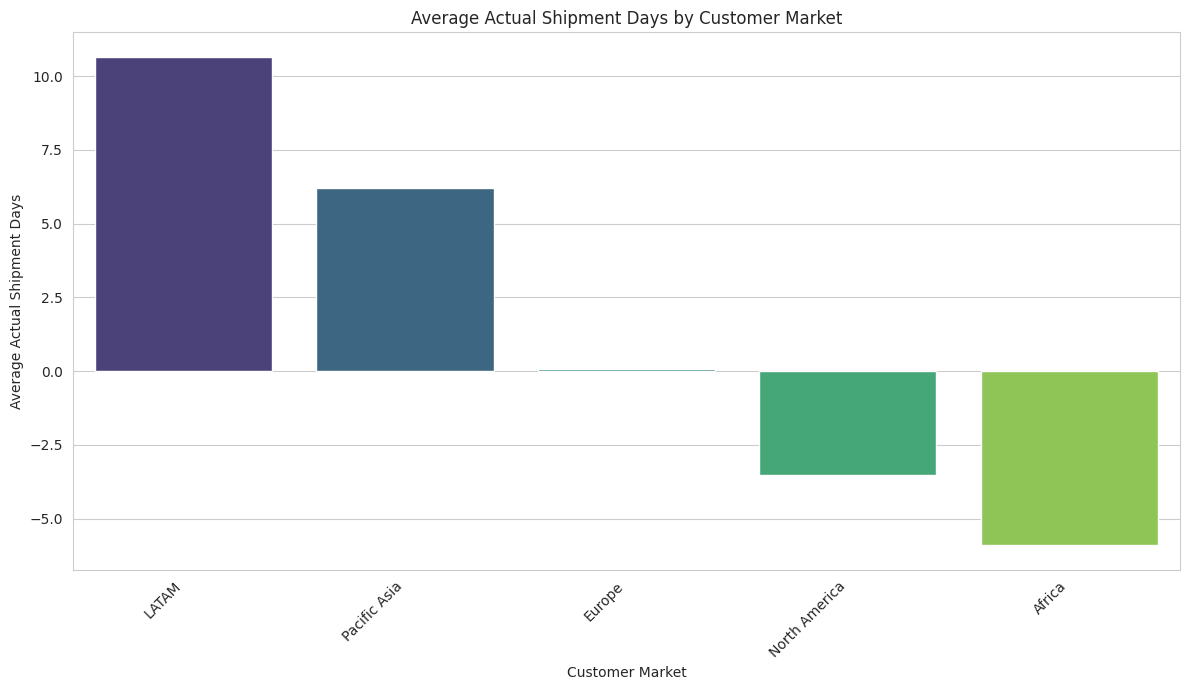

In [44]:
# 5. Bar plot for average 'actual_shipment_days' for each 'customer_market'
average_shipment_days_by_market = (
    df.groupby("customer_market")["actual_shipment_days"]
    .mean()
    .sort_values(ascending=False)
)
plt.figure(figsize=(12, 7))
sns.barplot(
    x=average_shipment_days_by_market.index,
    y=average_shipment_days_by_market.values,
    palette="viridis",
    hue=average_shipment_days_by_market.index,
    legend=False,
)
plt.title("Average Actual Shipment Days by Customer Market")
plt.xlabel("Customer Market")
plt.ylabel("Average Actual Shipment Days")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


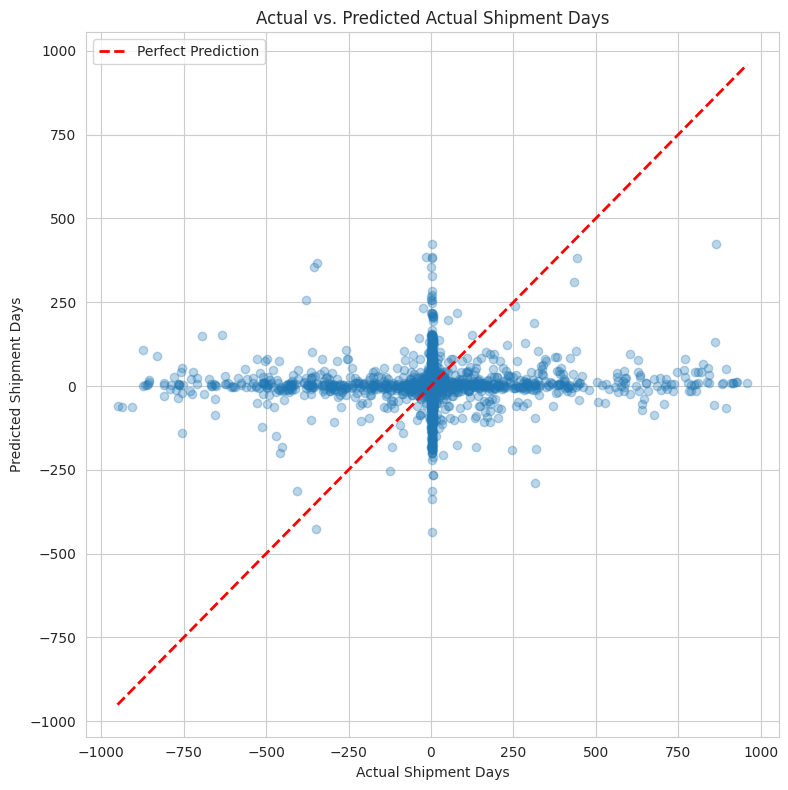

In [45]:

# 6. Scatter plot comparing actual vs. predicted 'actual_shipment_days'
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    "r--",
    lw=2,
    label="Perfect Prediction",
)
plt.title("Actual vs. Predicted Actual Shipment Days")
plt.xlabel("Actual Shipment Days")
plt.ylabel("Predicted Shipment Days")
plt.legend()
plt.tight_layout()
plt.show()


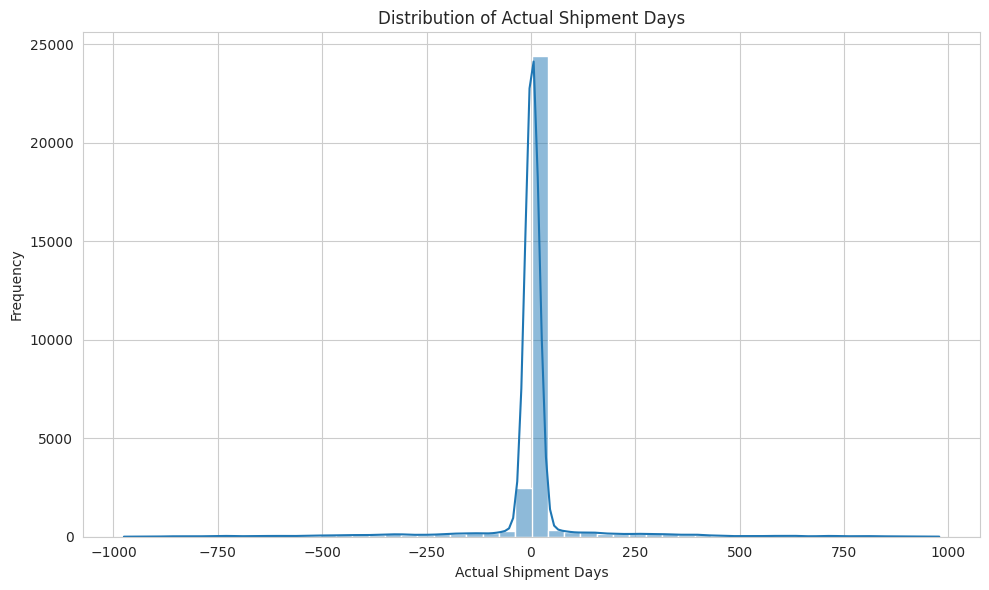

In [46]:

# Set a style for better aesthetics
sns.set_style("whitegrid")

# 1. Histogram for 'actual_shipment_days'
plt.figure(figsize=(10, 6))
sns.histplot(df["actual_shipment_days"], kde=True, bins=50)
plt.title("Distribution of Actual Shipment Days")
plt.xlabel("Actual Shipment Days")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


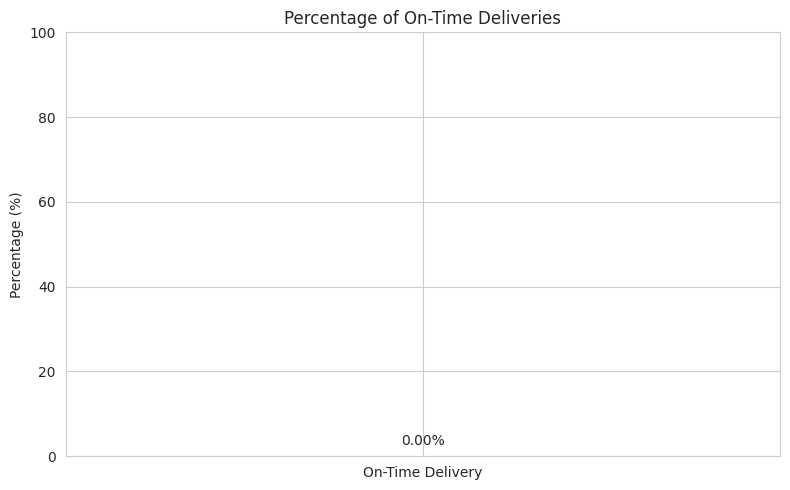

In [48]:

# 2. Bar plot for 'percentage_on_time_delivery'
plt.figure(figsize=(8, 5))
plt.bar(["On-Time Delivery"], [percentage_on_time_delivery], color="skyblue")
plt.title("Percentage of On-Time Deliveries")
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)
for i, v in enumerate([percentage_on_time_delivery]):
    plt.text(i, v + 2, f"{v:.2f}%", ha="center", va="bottom")
plt.tight_layout()
plt.show()


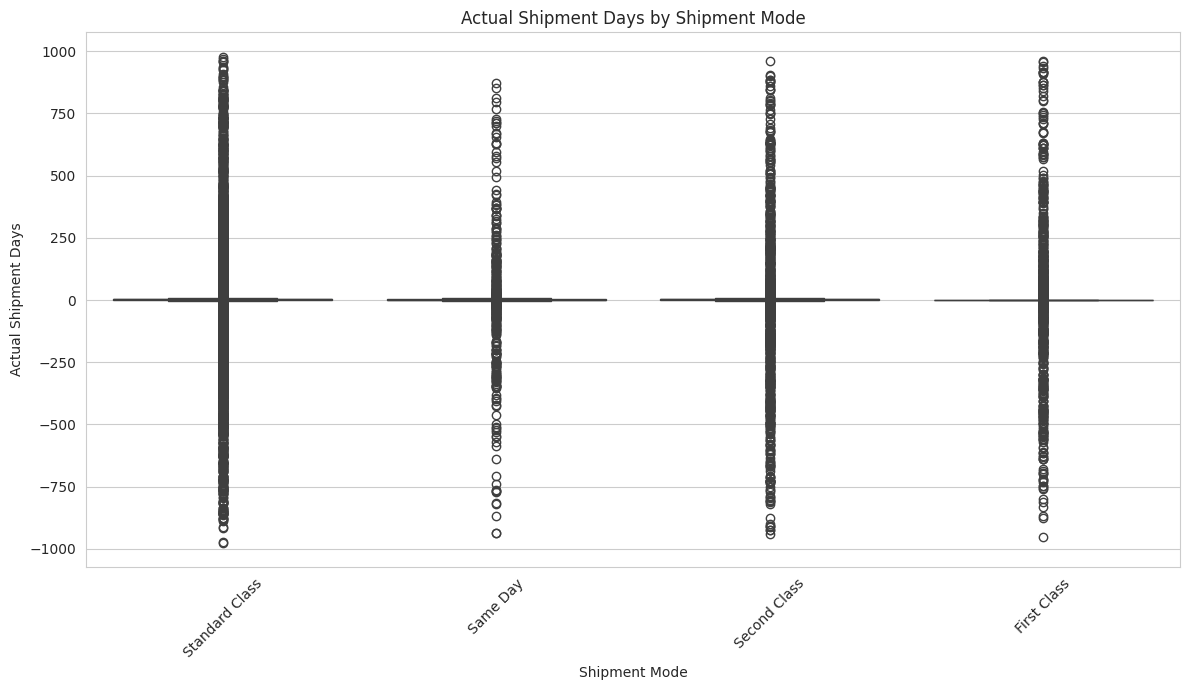

In [49]:
# 3. Box plot to show relationship between 'shipment_mode' and 'actual_shipment_days'
plt.figure(figsize=(12, 7))
sns.boxplot(x="shipment_mode", y="actual_shipment_days", data=df)
plt.title("Actual Shipment Days by Shipment Mode")
plt.xlabel("Shipment Mode")
plt.ylabel("Actual Shipment Days")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

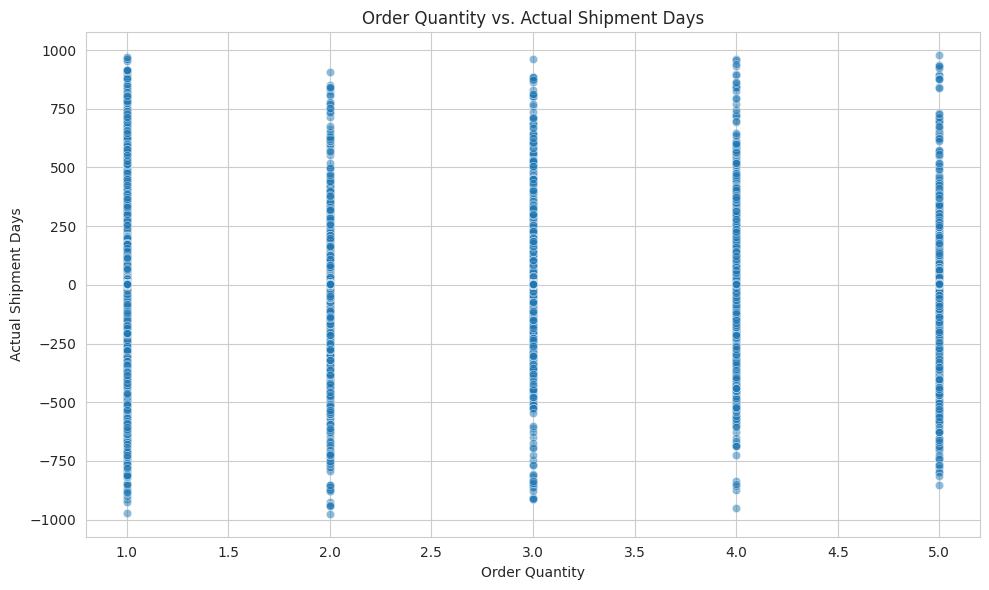

In [50]:
# 4. Scatter plot for 'order_quantity' and 'actual_shipment_days'
plt.figure(figsize=(10, 6))
sns.scatterplot(x="order_quantity", y="actual_shipment_days", data=df, alpha=0.5)
plt.title("Order Quantity vs. Actual Shipment Days")
plt.xlabel("Order Quantity")
plt.ylabel("Actual Shipment Days")
plt.tight_layout()
plt.show()

/tmp/ipython-input-3810805916.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


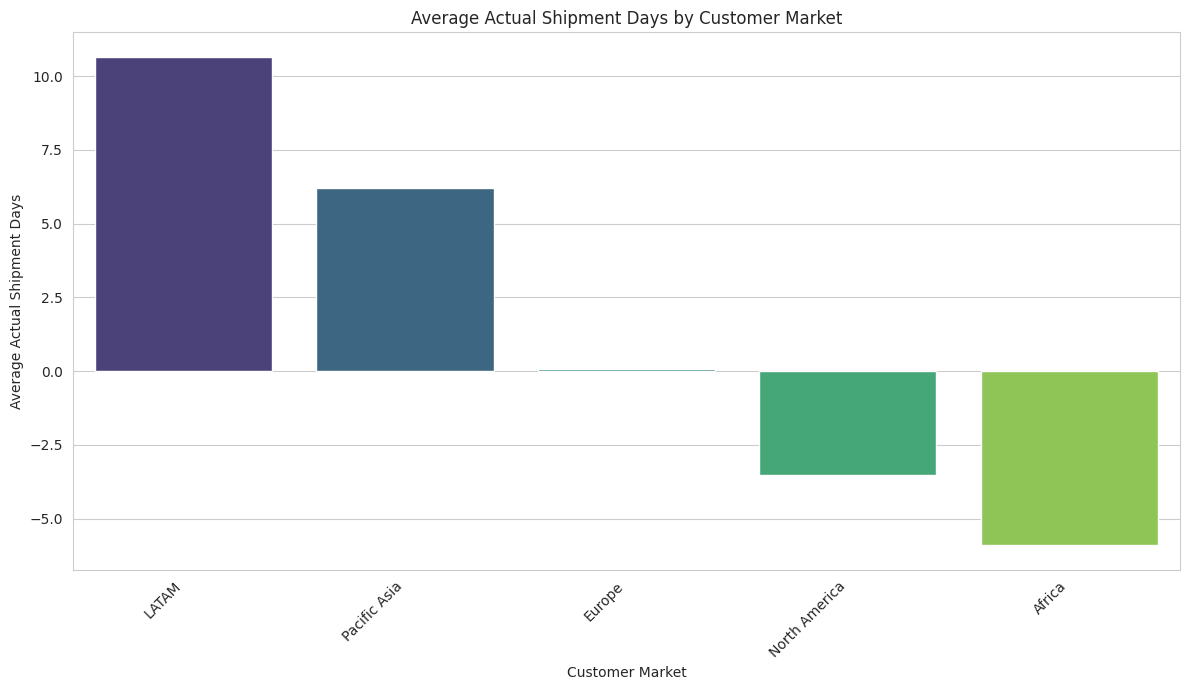

In [51]:

# 5. Bar plot for average 'actual_shipment_days' for each 'customer_market'
average_shipment_days_by_market = (
    df.groupby("customer_market")["actual_shipment_days"]
    .mean()
    .sort_values(ascending=False)
)
plt.figure(figsize=(12, 7))
sns.barplot(
    x=average_shipment_days_by_market.index,
    y=average_shipment_days_by_market.values,
    palette="viridis",
)
plt.title("Average Actual Shipment Days by Customer Market")
plt.xlabel("Customer Market")
plt.ylabel("Average Actual Shipment Days")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



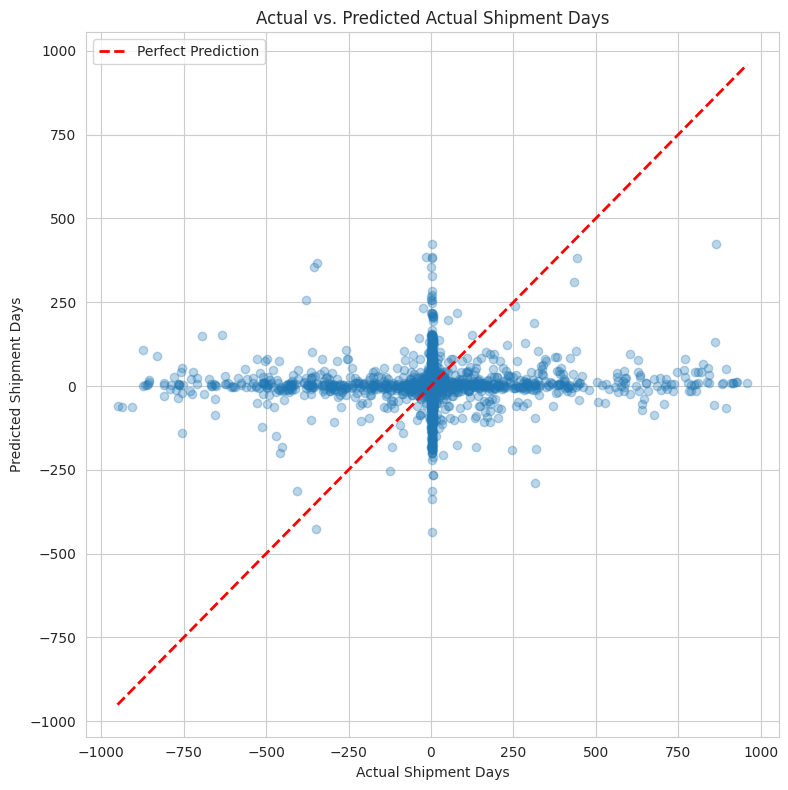

In [52]:
# 6. Scatter plot comparing actual vs. predicted 'actual_shipment_days'
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    "r--",
    lw=2,
    label="Perfect Prediction",
)
plt.title("Actual vs. Predicted Actual Shipment Days")
plt.xlabel("Actual Shipment Days")
plt.ylabel("Predicted Shipment Days")
plt.legend()
plt.tight_layout()
plt.show()